## Part 3 (Zipf’s Law, data visualisation)

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

C:\Users\behdad\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [3]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
text      1596041 non-null object
target    1596041 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [5]:
len(cvec.get_feature_names())

264939

In [6]:
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [7]:
term_freq_df.head()

,0,1
aa,160,92
aaa,93,54
aaaa,45,29
aaaaa,26,12
aaaaaa,16,12


In [8]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313162,252567,565729
the,257836,265998,523834
my,190775,125955,316730
it,157448,147786,305234
and,153958,149642,303600
you,103844,198245,302089
not,194724,86861,281585
is,133432,111191,244623
in,115542,101160,216702
for,98999,117369,216368


In [9]:
len(term_freq_df)

264939

In [10]:
term_freq_df.to_csv('term_freq_df.csv',encoding='utf-8')

## Zipf's Law

Zipf's Law is first presented by French stenographer Jean-Baptiste Estoup and later named after the American linguist George Kingsley Zipf.
Zipf's Law states that a small number of words are used all the time, while the vast majority are used very rarely. There is nothing surprising about this, we know that we use some of the words very frequently, such as "the", "of", etc, and we rarely use the words like "aardvark" (aardvark is an animal species native to Africa).
However, what's interesting is that "given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc."

In other words, the rth most frequent word has a frequency f(r) that scales according to
$${f(r)} \propto \frac{1}{r^\alpha}$$
for
$$\alpha \approx {1}$$

Let's see how the tweet tokens and their frequencies look like on a plot.

Text(0.5, 1.0, 'Top 500 tokens in tweets')

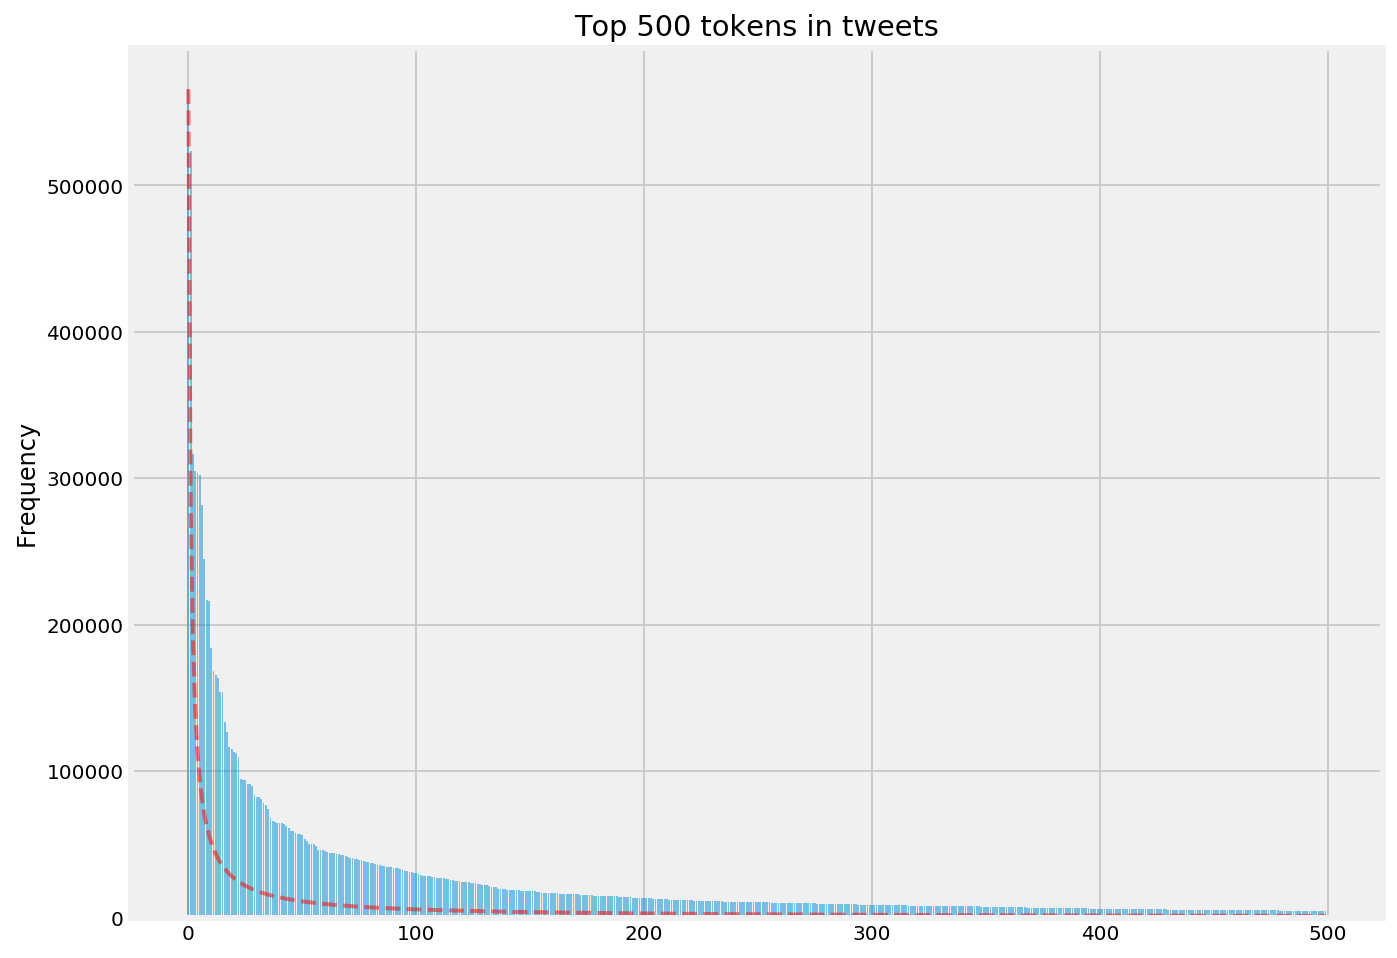

In [11]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

On the X-axis is the rank of the frequency from highest rank from left up to 500th rank to the right.
Y-axis is the frequency observed in the corpus (in this case, "Sentiment140" dataset).
One thing to note is that the actual observations in most cases does not strictly follow Zipf's distribution, but rather follow the trend of "near-Zipfian" distribution.

Even though we can see the plot follows the trend of Zipf's Law, but it looks like it has more area above the expected Zipf curve in higher ranked words.

Another way to plot this is on a log-log graph, with X-axis being log(rank), Y-axis being log(frequency).
By plotting on the log-log scale the result will yield roughly linear line on the graph.

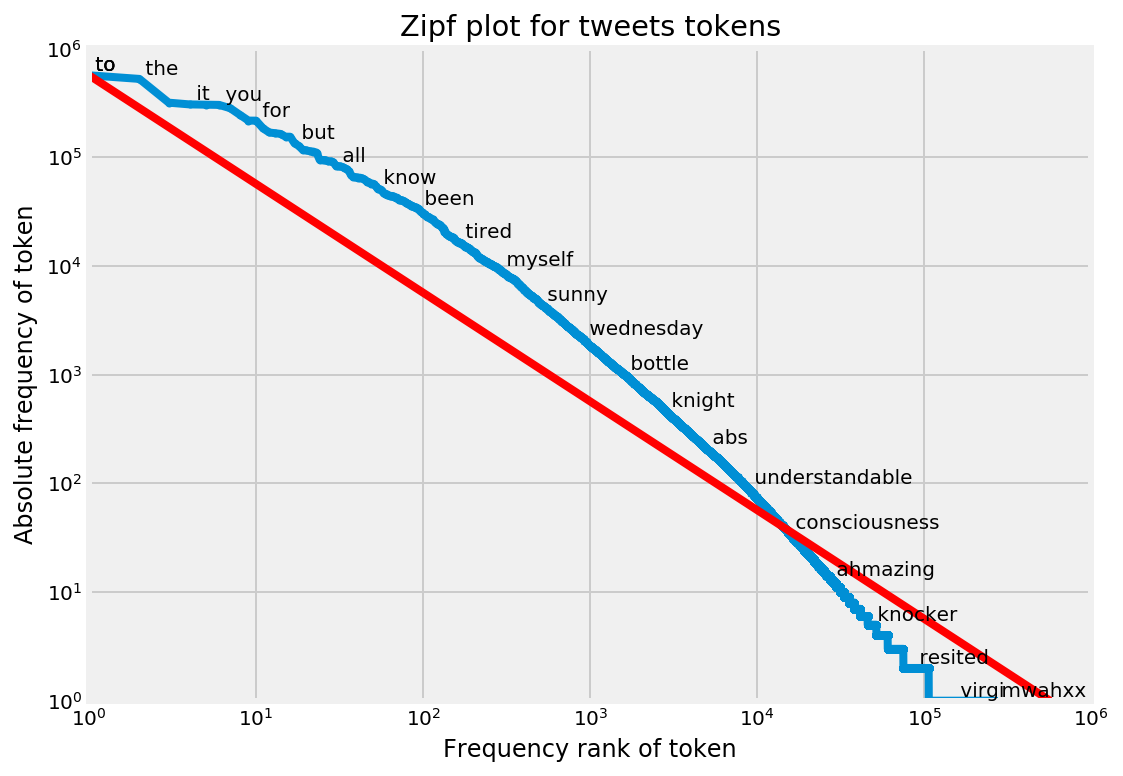

In [12]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

Again we see a roughly linear curve, but deviating above the expected line on higher ranked words, and at the lower ranks we see the actual observation line lies below the expected linear line.

In [13]:
term_freq_df = pd.read_csv('term_freq_df.csv',index_col=0, encoding='utf_8')

At least, we proved that even the tweet tokens follow "near-Zipfian" distribution, but this introduced me to a curiosity about the deviation from the Zipf's Law. Even though the law itself states that the actual observation follows "near-Zipfian" rather than strictly bound to the law, but is the area we observed above the expected line in higher ranks just by chance? Or does it mean that tweets use frequent words more heavily than other text corpora? Is there statistically significant difference compared to other text corpora?

Even though all of these sounds like very interesting research subjects, but it is beyond the scope of this project, and I will have to move to the next step of data visualisation.

## Tweets Tokens Visualisation

After having seen how the tokens are distributed through the whole corpus, the next question in my head is how different the tokens in two different classes(positive, negative). This time, the stop words will not help much, because of the same high-frequency words, such as "the", "to", will equally frequent in both classes. If these stop words dominate both of the classes, I won't be able to have a meaningful result. So, I decided to remove stop words, and also will limit the max_features to 10,000 with countvectorizer.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(my_df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [14]:
document_matrix = cvec.transform(my_df.text)

In [15]:
%%time
neg_batches = np.linspace(0,798179,10).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print (neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

88686 entries' term freuquency calculated
177373 entries' term freuquency calculated
266059 entries' term freuquency calculated
354746 entries' term freuquency calculated
443432 entries' term freuquency calculated
532119 entries' term freuquency calculated
620805 entries' term freuquency calculated
709492 entries' term freuquency calculated
798179 entries' term freuquency calculated
Wall time: 6min 48s


In [16]:
%%time
pos_batches = np.linspace(798179,1596019,10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print (pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

886827 entries' term freuquency calculated
975476 entries' term freuquency calculated
1064125 entries' term freuquency calculated
1152774 entries' term freuquency calculated
1241423 entries' term freuquency calculated
1330072 entries' term freuquency calculated
1418721 entries' term freuquency calculated
1507370 entries' term freuquency calculated
1596019 entries' term freuquency calculated
Wall time: 9min 56s


In [17]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
just,64002,62943,126945
good,29208,62117,91325
day,41372,48188,89560
like,41047,37522,78569
today,38116,30100,68216
work,45419,19529,64948
love,16989,47695,64684
going,33689,30939,64628
got,33408,28037,61445
lol,23123,36118,59241


Let's see what are the top 50 words in negative tweets on a bar chart.

Text(0.5, 1.0, 'Top 50 tokens in negative tweets')

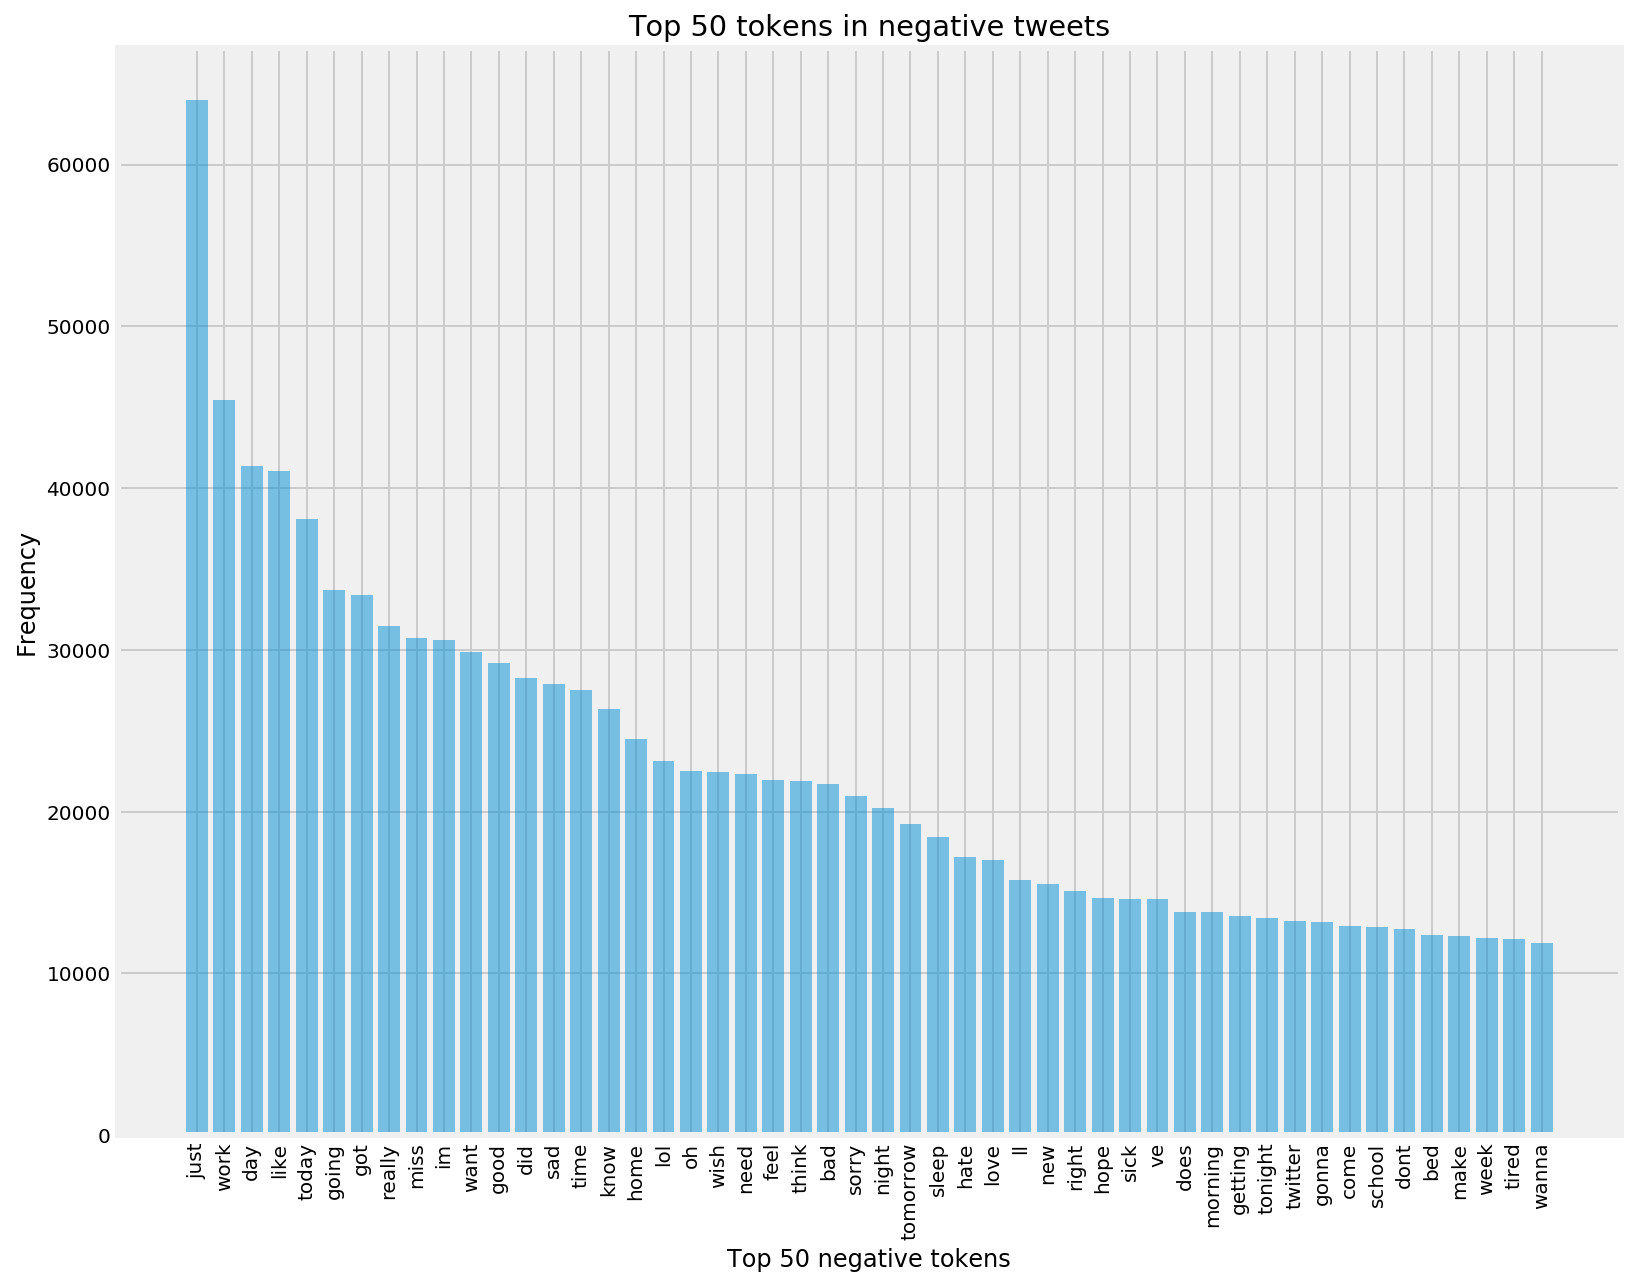

In [18]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Even though some of the top 50 tokens can provide some information about the negative tweets, some neutral words such as "just", "day", are one of the most frequent tokens. Even though these are the actual high-frequency words, but it is difficult to say that these words are all important words in negative tweets that characterises the negative class.

Let's also take a look at top 50 positive tokens on a bar chart.

Text(0.5, 1.0, 'Top 50 tokens in positive tweets')

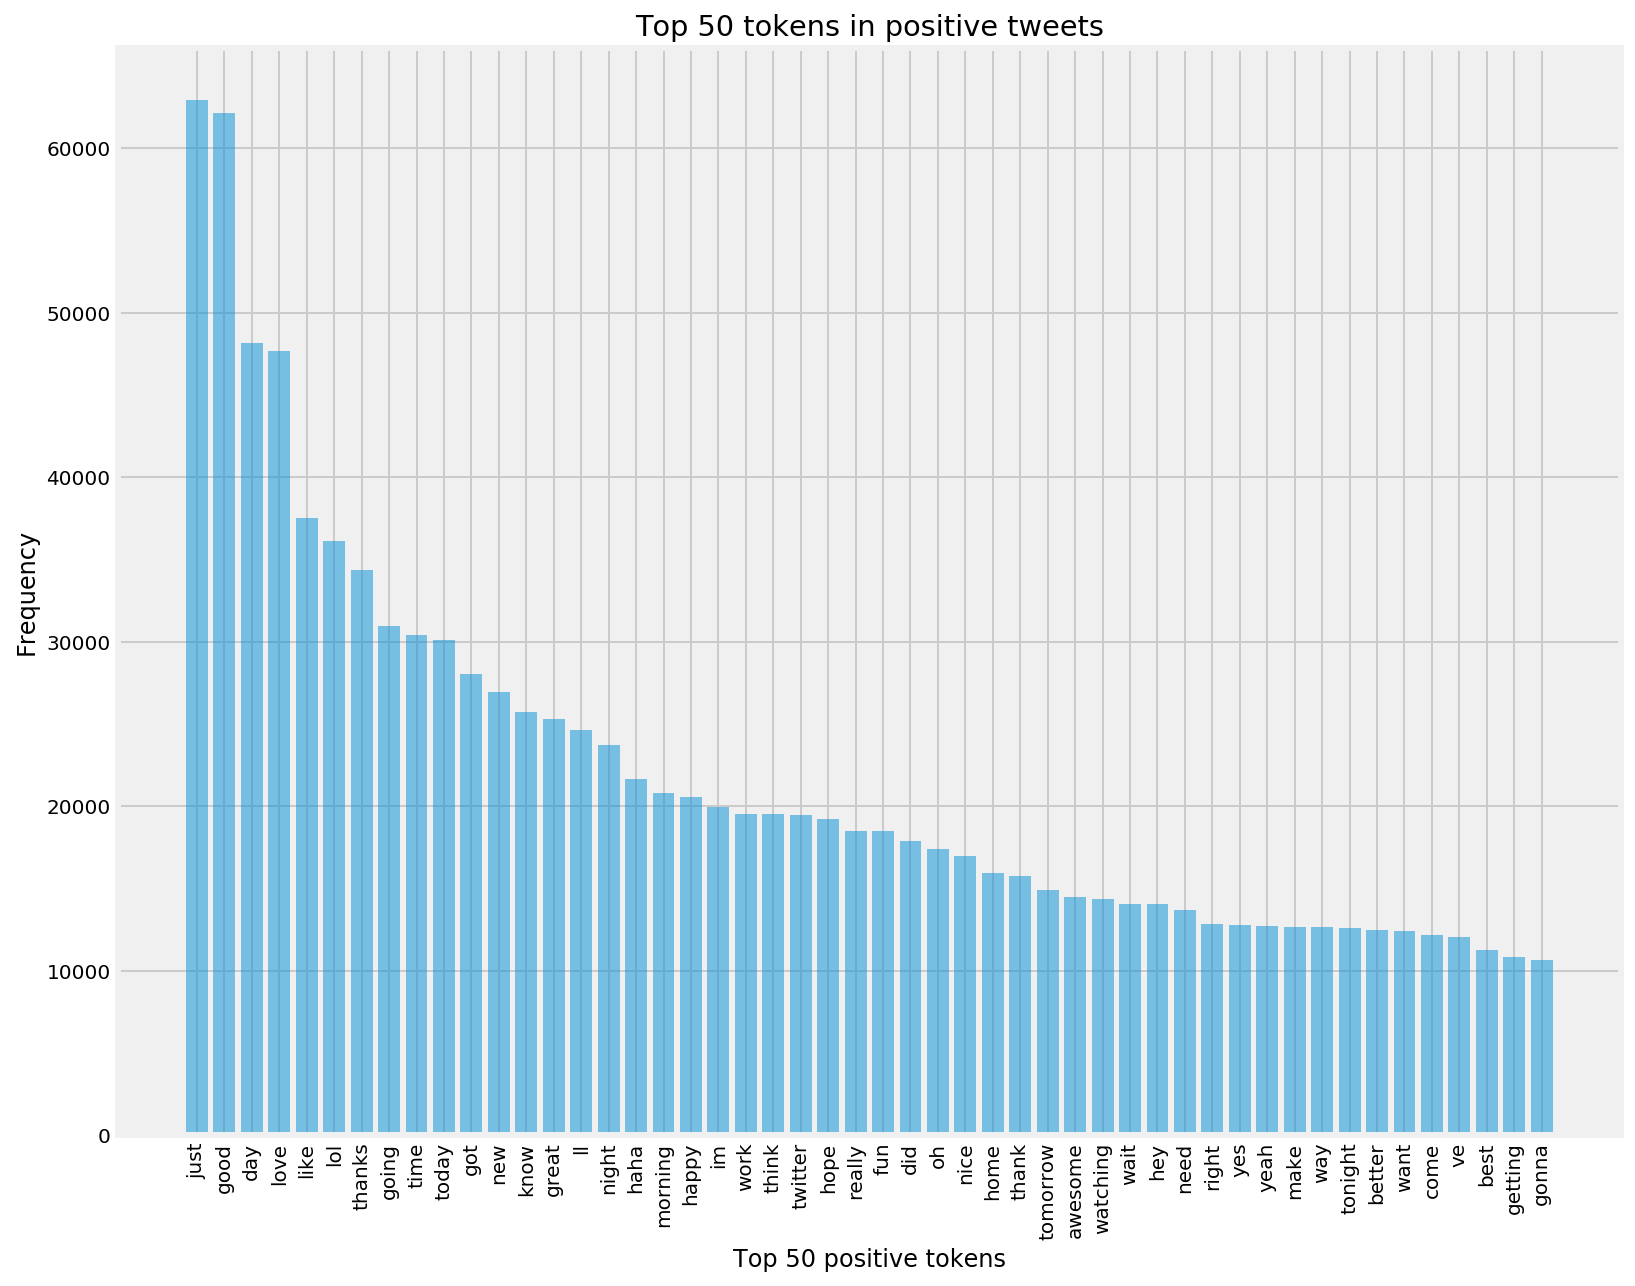

In [19]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Again, neutral words like "just", "day", are quite high up in the rank.

What if we plot, negative frequency of a word on X-axis, and positive frequency on Y-axis?

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

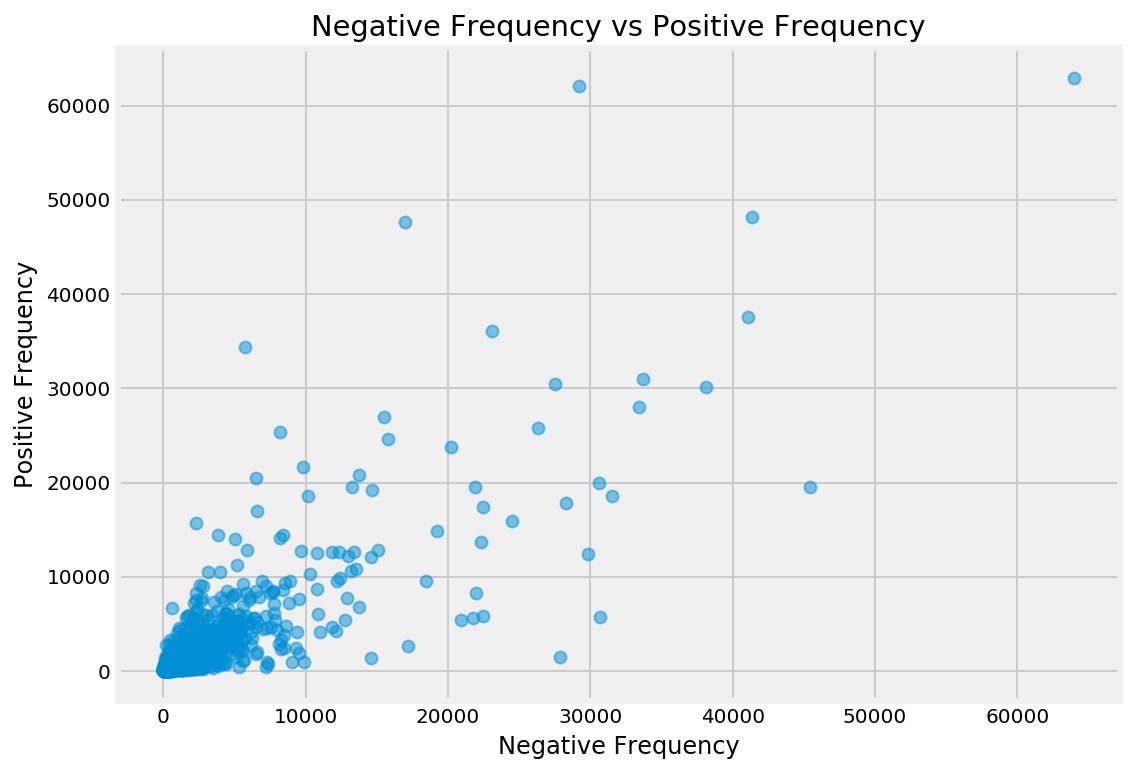

In [20]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

Most of the words are below 10,000 on both X-axis and Y-axis, and we cannot see a meaningful relation between negative and positive frequency.

In order to come up with a meaningful metric which can characterise important tokens in each class, I borrowed a metric presented by Jason Kessler in PyData 2017 Seattle. In the talk, he presented a Python library called Scattertext. Even though I did not make use of the library, the metrics used in the Scattertext as a way of visualising text data are very useful in filtering meaningful tokens from the frequency data.

Intuitively, if a word appears more often in one class compared to another, this can be a good measure of how much the word is meaningful to characterise the class.
In the below code I named it as 'pos_rate', and as you can see from the calculation of the code,
this is defined as
$${pos\_rate} = \frac{positive\ frequency} {positive\ frequency + negative\ frequency}$$

In [21]:
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
emailunlimited,0,100,100,1.000000
dividends,0,83,83,1.000000
mileymonday,0,161,161,1.000000
shareholder,1,80,81,0.987654
fuzzball,2,99,101,0.980198
recommends,3,109,112,0.973214
delongeday,6,162,168,0.964286
atcha,3,80,83,0.963855
timestamp,3,68,71,0.957746
shaundiviney,4,89,93,0.956989


Words with highest pos_rate have zero frequency in the negative tweets, but overall frequency of these words are too low to think of it as a guideline for positive tweets.

Another metric is the frequency a words occurs in the class.
This is defined as
$${pos\_freq\_pct} = \frac {positive\ frequency} {\Sigma positive\ frequency}$$

In [22]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
just,64002,62943,126945,0.495829,0.014396
good,29208,62117,91325,0.680175,0.014207
day,41372,48188,89560,0.538053,0.011021
love,16989,47695,64684,0.737354,0.010908
like,41047,37522,78569,0.477567,0.008582
lol,23123,36118,59241,0.609679,0.008261
thanks,5768,34375,40143,0.856314,0.007862
going,33689,30939,64628,0.478724,0.007076
time,27526,30429,57955,0.525045,0.006960
today,38116,30100,68216,0.441245,0.006884


But since pos_freq_pct is just the frequency scaled over the total sum of the frequency, the rank of pos_freq_pct is exactly same as just the positive frequency.

What we can do now is to combine pos_rate, pos_freq_pct together to come up with a metric which reflects both pos_rate and pos_freq_pct. Even though both of these can take a value ranging from 0 to 1, pos_rate has much wider range actually spanning from 0 to 1, while all the pos_freq_pct values are squashed within the range smaller than 0.015. If we average these two numbers, pos_rate will be too dominant, and will not reflect both metrics effectively.

So here we use harmonic mean instead of arithmetic mean. "Since the harmonic mean of a list of numbers tends strongly toward the least elements of the list, it tends (compared to the arithmetic mean) to mitigate the impact of large outliers and aggravate the impact of small ones."
The harmonic mean H of the positive real number x1,x2,...xn is defined as
$${H} = \frac {n}{\sum_{i=1}^{n}\ \frac{1}{x_i}}$$

In [23]:
from scipy.stats import hmean

term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])
                                                                   if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
just,64002,62943,126945,0.495829,0.014396,0.027979
good,29208,62117,91325,0.680175,0.014207,0.027833
day,41372,48188,89560,0.538053,0.011021,0.021600
love,16989,47695,64684,0.737354,0.010908,0.021499
like,41047,37522,78569,0.477567,0.008582,0.016861
lol,23123,36118,59241,0.609679,0.008261,0.016300
thanks,5768,34375,40143,0.856314,0.007862,0.015581
going,33689,30939,64628,0.478724,0.007076,0.013946
time,27526,30429,57955,0.525045,0.006960,0.013737
today,38116,30100,68216,0.441245,0.006884,0.013557


The harmonic mean rank seems like the same as pos_freq_pct. By calculating the harmonic mean, the impact of small value (in this case, pos_freq_pct) is too aggravated and ended up dominating the mean value. This is again exactly same as just the frequency value rank and doesn't provide a meaningful result.

What we can try next is to get the CDF (Cumulative Distribution Function) value of both pos_rate and pos_freq_pct.
CDF can be explained as "distribution function of X, evaluated at x, is the probability that X will take a value less than or equal to x". By calculating CDF value, we can see where the value of either pos_rate or pos_freq_pct lies in the distribution in terms of cumulative manner. In the below result of the code, we can see a word "welcome" with pos_rate_normcdf of 0.995625, and pos_freq_pct_normcdf of 0.999354. This means roughly 99.56% of the tokens will take a pos_rate value less than or equal to 0.91535, and 99.99% will take a pos_freq_pct value less than or equal to 0.001521.

Next, we calculate a harmonic mean of these two CDF values, as we did earlier.
By calculating the harmonic mean, we can see that pos_normcdf_hmean metric provides a more meaningful measure of how important a word is within the class.

In [24]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
welcome,620,6702,7322,0.915324,0.001533,0.003061,0.995624,0.999369,0.997493
thank,2282,15736,18018,0.873349,0.003599,0.007169,0.990793,1.000000,0.995375
thanks,5768,34375,40143,0.856314,0.007862,0.015581,0.987772,1.000000,0.993848
awesome,3821,14469,18290,0.791088,0.003309,0.006591,0.967042,1.000000,0.983245
glad,2273,8254,10527,0.784079,0.001888,0.003767,0.963660,0.999971,0.981480
follow,2551,9155,11706,0.782078,0.002094,0.004177,0.962644,0.999996,0.980965
enjoy,1642,5876,7518,0.781591,0.001344,0.002683,0.962393,0.997441,0.979604
sweet,1610,5646,7256,0.778115,0.001291,0.002578,0.960563,0.996331,0.978121
yay,3165,10500,13665,0.768386,0.002401,0.004788,0.955055,1.000000,0.977011
hello,1122,4524,5646,0.801275,0.001035,0.002067,0.971490,0.982294,0.976862


Next step is to apply the same calculation to negative frequency of each word.

In [25]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])
                                                                   if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
sad,27907,1514,29421,0.051460,0.000346,0.000688,0.002399,0.710297,0.004781,0.948540,0.006095,0.012112,0.997601,1.000000,0.998799
hurts,7204,456,7660,0.059530,0.000104,0.000208,0.002807,0.503855,0.005583,0.940470,0.001573,0.003142,0.997193,0.999742,0.998466
sick,14616,1420,16036,0.088551,0.000325,0.000647,0.004845,0.693525,0.009623,0.911449,0.003192,0.006362,0.995155,1.000000,0.997572
sucks,9902,982,10884,0.090224,0.000225,0.000448,0.004995,0.610420,0.009910,0.909776,0.002163,0.004315,0.995005,0.999999,0.997496
poor,7333,719,8052,0.089295,0.000164,0.000328,0.004912,0.557659,0.009737,0.910705,0.001602,0.003198,0.995088,0.999799,0.997438
ugh,9055,998,10053,0.099274,0.000228,0.000455,0.005882,0.613575,0.011653,0.900726,0.001978,0.003947,0.994118,0.999995,0.997048
missing,7282,991,8273,0.119787,0.000227,0.000452,0.008426,0.612195,0.016624,0.880213,0.001590,0.003175,0.991574,0.999778,0.995659
headache,5317,421,5738,0.073371,0.000096,0.000192,0.003656,0.496667,0.007258,0.926629,0.001161,0.002320,0.996344,0.993812,0.995076
hate,17207,2614,19821,0.131880,0.000598,0.001190,0.010341,0.868741,0.020439,0.868120,0.003758,0.007484,0.989659,1.000000,0.994802
miss,30713,5676,36389,0.155981,0.001298,0.002575,0.015313,0.996497,0.030162,0.844019,0.006708,0.013310,0.984687,1.000000,0.992284


Now let's see how the values are converted on a plot. In order to compare, I will first plot neg_hmean vs pos_hmean, and neg_normcdf_hmean vs pos_normcdf_hmean.

Text(0.5, 1.0, 'neg_hmean vs pos_hmean')

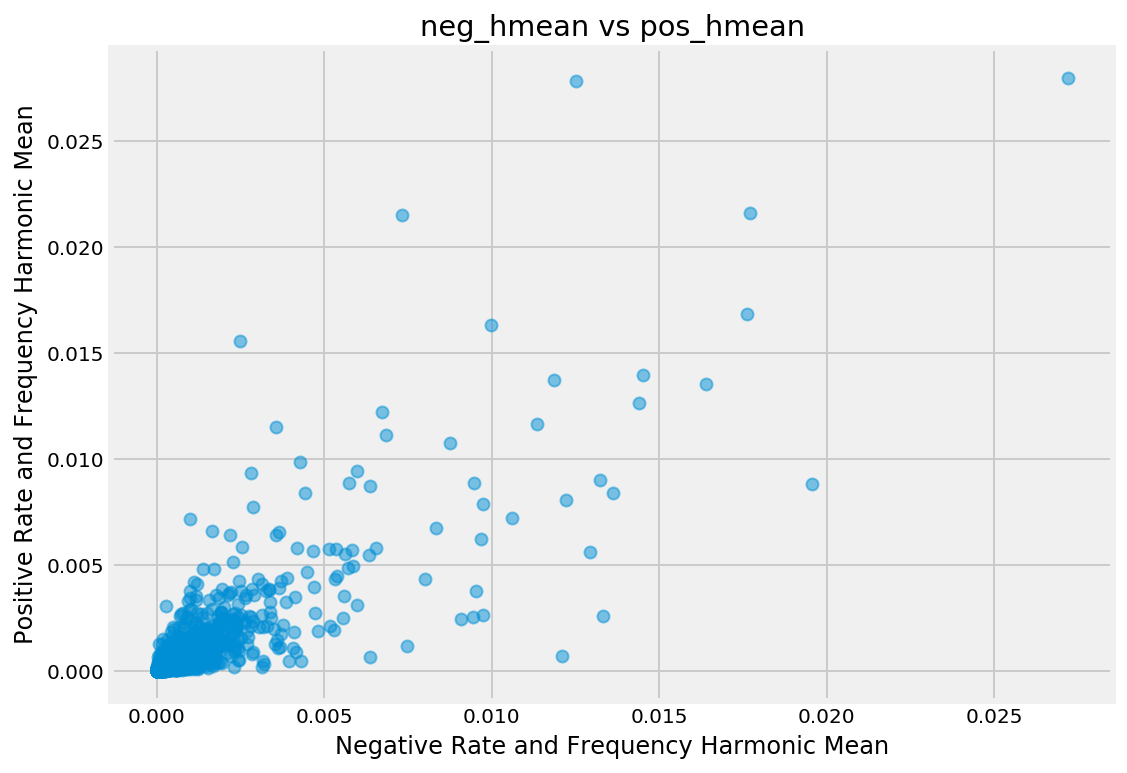

In [26]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Not much difference from the just frequency of positive and negative. How about the CDF harmonic mean?

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

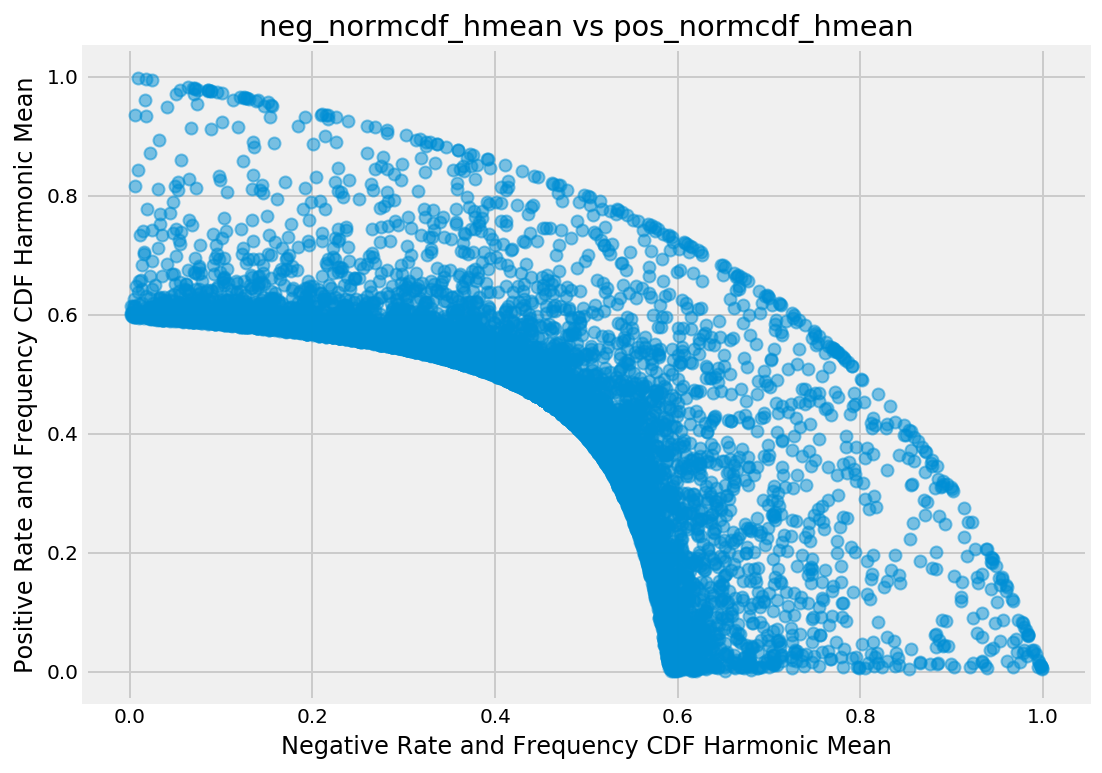

In [27]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

It seems like the harmonic mean of rate CDF and frequency CDF has created an interesting pattern on the plot. If a data point is near to upper left corner, it is more positive, and if it is closer to the bottom right corner, it is more negative.

It is good that the metric has created some meaningful insight out of frequency, but with text data, showing every token as just a dot is lacking important information on which token each data point represents. With 10,000 points, it is difficult to annotate all of the points on the plot. For this part, I have tried several methods and came to a conclusion that it is not very practical or feasible to directly annotate data points on the plot.

So I took an alternative method of the interactive plot with Bokeh. Bokeh is an interactive visualisation library for Python, which creates graphics in style of D3.js. Bokeh can output the result in HTML format or also within the Jupyter Notebook. And below is the plot created with Bokeh.

In [28]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
from bokeh.models import HoverTool
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...

If the Bokeh plot does not show properly above, you can access to the plot with following link.
https://s3.eu-west-2.amazonaws.com/ricksimages/hover.html

With above Bokeh plot, you can see what token each data point represents by hovering over the points. For example, the points in the top left corner show tokens like "thank", "welcome", "congrats", etc. And some of the tokens in bottom right corner are "sad", "hurts", "died", "sore", etc. And the colour of each dot is organised in "Inferno256" colour map in Python, so yellow is the most positive, while black is the most negative, and the colour gradually goes from black to purple to orange to yellow, as it goes from negative to positive.

Depending on which model I will use later for classification of positive and negative tweets, this metric can also come in handy.